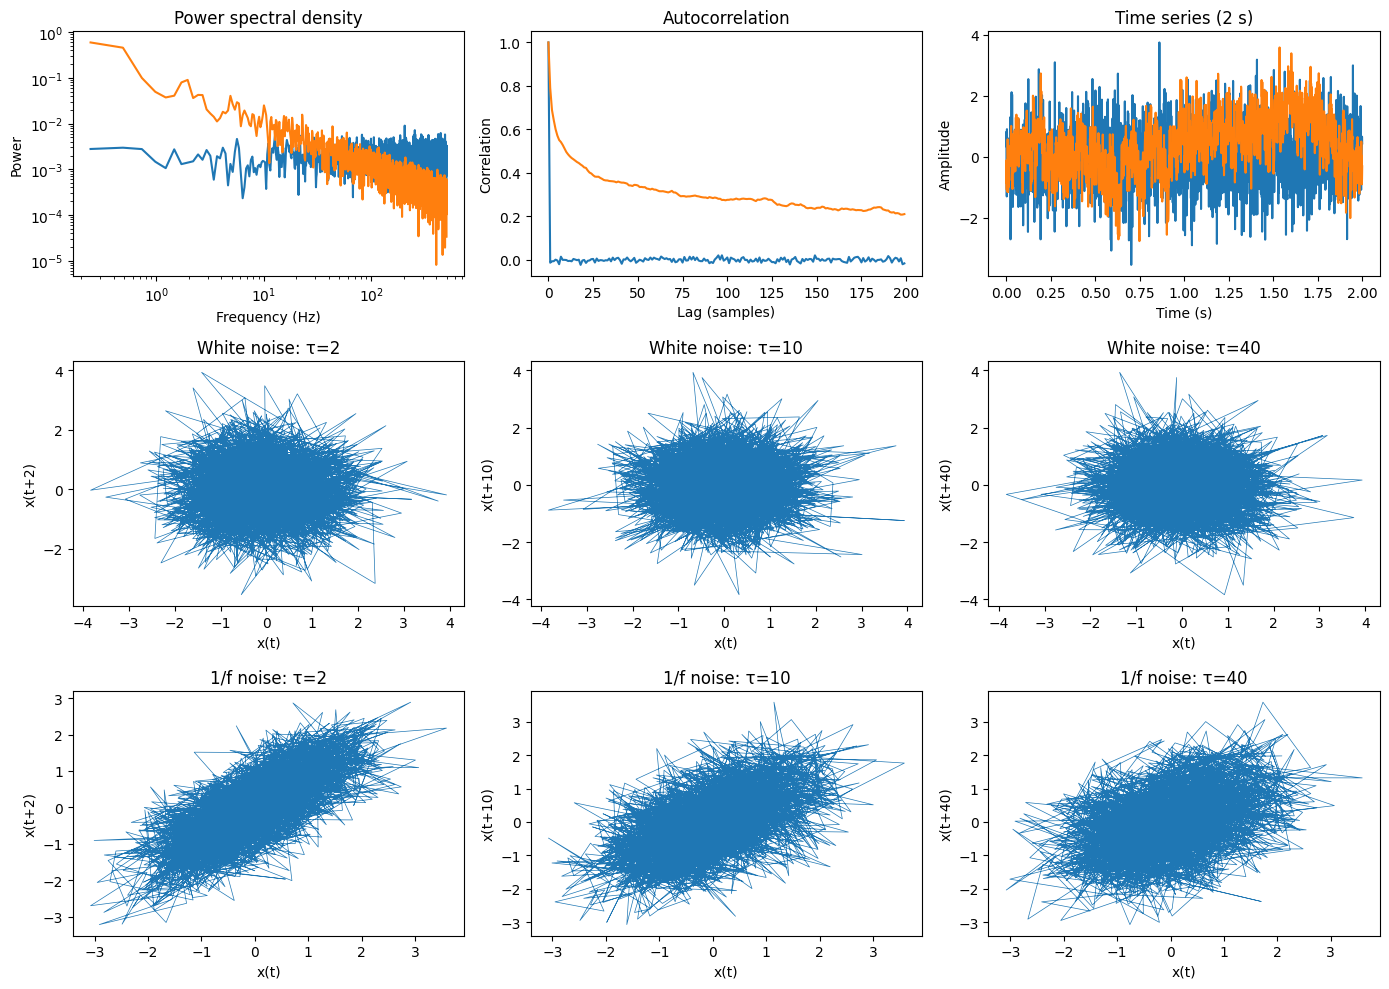

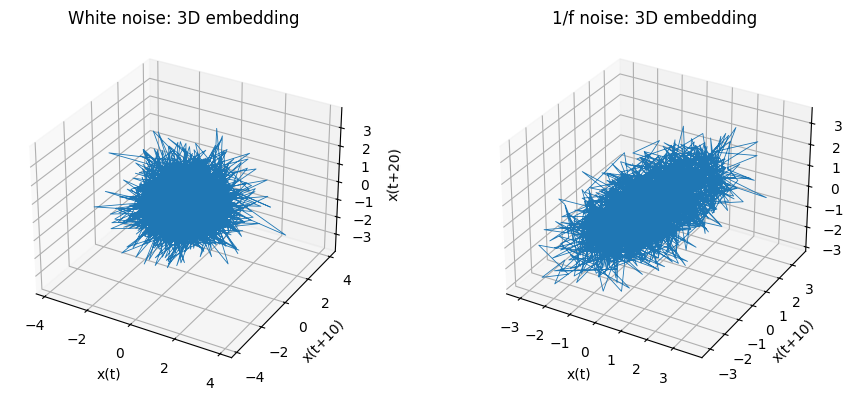

In [1]:
# Extended exploration with a grid of subfigures:
# - PSD comparison
# - Autocorrelation
# - 2D delay embeddings for multiple taus
# - 3D embedding (single tau)
#
# No explicit colors set, per instructions.

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

def make_white_noise(n, seed=0):
    rng = np.random.default_rng(seed)
    return rng.standard_normal(n)

def make_1_over_f_noise(n, fs=1.0, alpha=1.0, seed=0):
    rng = np.random.default_rng(seed)
    freqs = np.fft.rfftfreq(n, d=1.0/fs)
    re = rng.standard_normal(freqs.shape)
    im = rng.standard_normal(freqs.shape)
    X = re + 1j * im
    mag_shape = np.ones_like(freqs)
    mag_shape[1:] = 1.0 / (freqs[1:] ** (alpha / 2.0))
    mag_shape[0] = 0.0
    X = X * mag_shape
    x = np.fft.irfft(X, n=n)
    x = (x - np.mean(x)) / np.std(x)
    return x

def lag_embed(x, tau, m):
    n = len(x)
    T = n - (m - 1) * tau
    Y = np.column_stack([x[i*tau:i*tau+T] for i in range(m)])
    return Y

def autocorr(x, max_lag):
    x = x - np.mean(x)
    ac = np.correlate(x, x, mode="full")
    ac = ac[ac.size // 2:]
    ac = ac / ac[0]
    return ac[:max_lag]

# Parameters
n = 12000
fs = 1000.0
alpha = 1.0
seed = 1

taus = [2, 10, 40]
m = 2

x_white = make_white_noise(n, seed=seed)
x_pink  = make_1_over_f_noise(n, fs=fs, alpha=alpha, seed=seed)

# PSD
f_w, Pxx_w = welch(x_white, fs=fs, nperseg=4096)
f_p, Pxx_p = welch(x_pink,  fs=fs, nperseg=4096)

# Autocorrelation
max_lag = 200
ac_w = autocorr(x_white, max_lag)
ac_p = autocorr(x_pink,  max_lag)

# Figure layout
fig = plt.figure(figsize=(14, 10))

# --- PSD ---
ax = fig.add_subplot(3, 3, 1)
ax.loglog(f_w[1:], Pxx_w[1:])
ax.loglog(f_p[1:], Pxx_p[1:])
ax.set_title("Power spectral density")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Power")

# --- Autocorrelation ---
ax = fig.add_subplot(3, 3, 2)
ax.plot(ac_w)
ax.plot(ac_p)
ax.set_title("Autocorrelation")
ax.set_xlabel("Lag (samples)")
ax.set_ylabel("Correlation")

# --- Time series snippet ---
ax = fig.add_subplot(3, 3, 3)
t = np.arange(2000) / fs
ax.plot(t, x_white[:2000])
ax.plot(t, x_pink[:2000])
ax.set_title("Time series (2 s)")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Amplitude")

# --- 2D delay embeddings for different taus ---
for i, tau in enumerate(taus):
    Yw = lag_embed(x_white, tau=tau, m=m)[::5]
    Yp = lag_embed(x_pink,  tau=tau, m=m)[::5]

    ax = fig.add_subplot(3, 3, 4 + i)
    ax.plot(Yw[:, 0], Yw[:, 1], linewidth=0.5)
    ax.set_title(f"White noise: τ={tau}")
    ax.set_xlabel("x(t)")
    ax.set_ylabel(f"x(t+{tau})")

    ax = fig.add_subplot(3, 3, 7 + i)
    ax.plot(Yp[:, 0], Yp[:, 1], linewidth=0.5)
    ax.set_title(f"1/f noise: τ={tau}")
    ax.set_xlabel("x(t)")
    ax.set_ylabel(f"x(t+{tau})")

plt.tight_layout()
plt.show()

# --- Separate 3D embedding figure ---
tau_3d = 10
Yw3 = lag_embed(x_white, tau_3d, 3)[::5]
Yp3 = lag_embed(x_pink,  tau_3d, 3)[::5]

fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(1, 2, 1, projection="3d")
ax1.plot(Yw3[:, 0], Yw3[:, 1], Yw3[:, 2], linewidth=0.6)
ax1.set_title("White noise: 3D embedding")
ax1.set_xlabel("x(t)")
ax1.set_ylabel(f"x(t+{tau_3d})")
ax1.set_zlabel(f"x(t+{2*tau_3d})")

ax2 = fig.add_subplot(1, 2, 2, projection="3d")
ax2.plot(Yp3[:, 0], Yp3[:, 1], Yp3[:, 2], linewidth=0.6)
ax2.set_title("1/f noise: 3D embedding")
ax2.set_xlabel("x(t)")
ax2.set_ylabel(f"x(t+{tau_3d})")
ax2.set_zlabel(f"x(t+{2*tau_3d})")

plt.tight_layout()
plt.show()


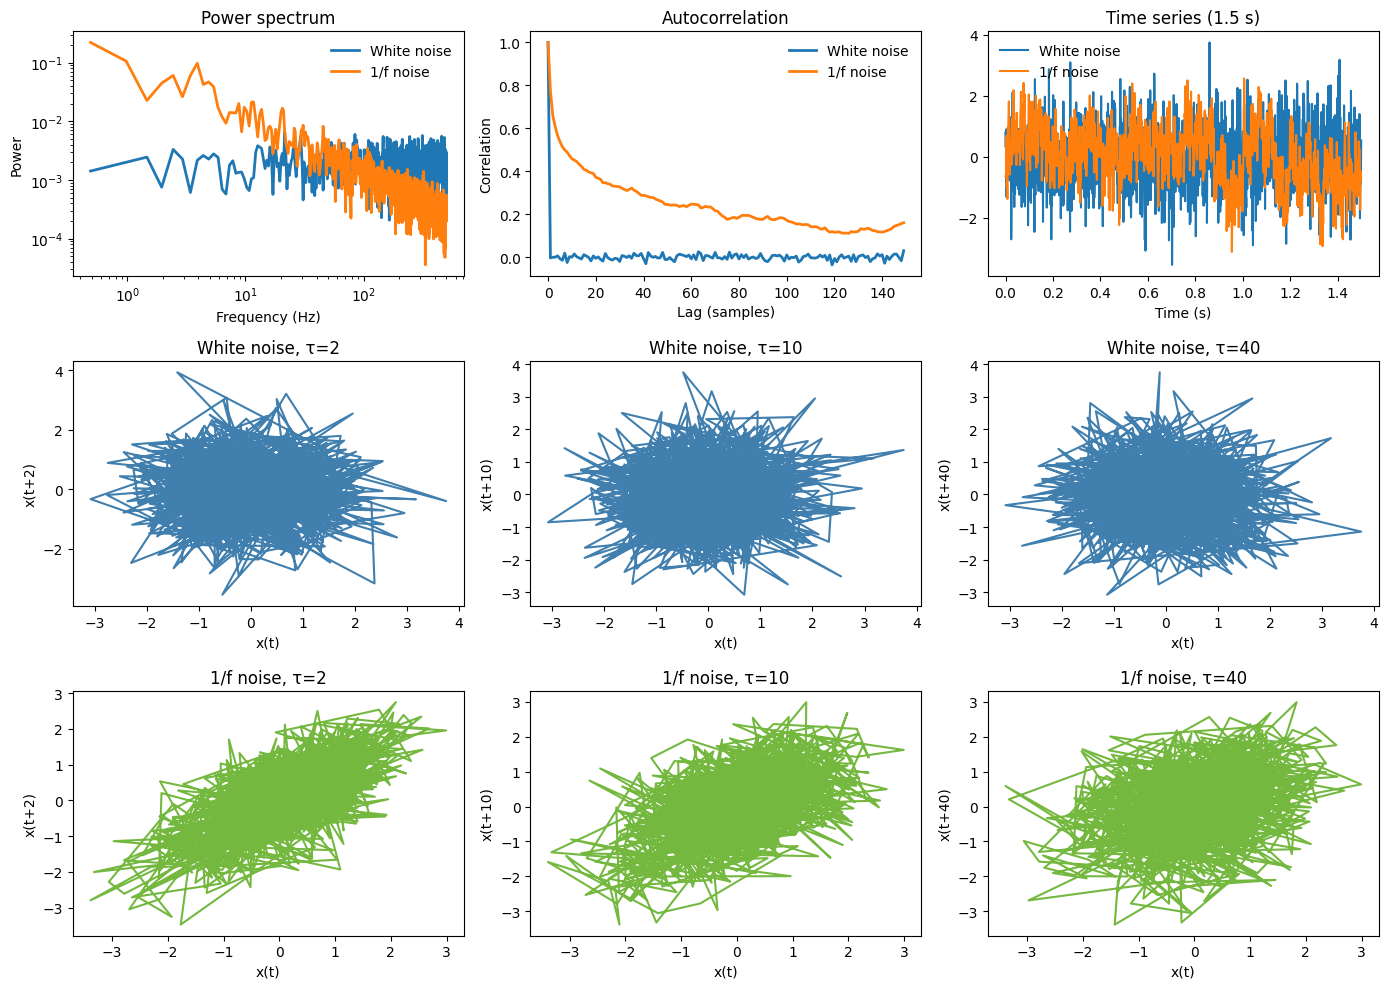

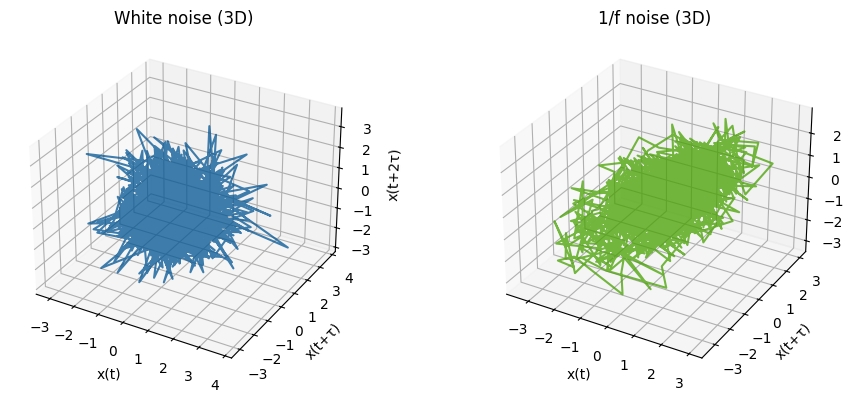

In [17]:
# Replot with matched colors and semi-transparent trajectories

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

# -------------------------
# Signal generators
# -------------------------
def make_white_noise(n, seed=0):
    rng = np.random.default_rng(seed)
    return rng.standard_normal(n)

def make_1_over_f_noise(n, fs=1.0, alpha=1.0, seed=0):
    rng = np.random.default_rng(seed)
    freqs = np.fft.rfftfreq(n, d=1.0/fs)
    X = rng.standard_normal(freqs.shape) + 1j*rng.standard_normal(freqs.shape)
    mag = np.ones_like(freqs)
    mag[1:] = 1.0 / (freqs[1:] ** (alpha/2))
    mag[0] = 0.0
    x = np.fft.irfft(X * mag, n=n)
    return (x - np.mean(x)) / np.std(x)

def lag_embed(x, tau, m):
    T = len(x) - (m - 1) * tau
    return np.column_stack([x[i*tau:i*tau+T] for i in range(m)])

def autocorr(x, L):
    x = x - np.mean(x)
    c = np.correlate(x, x, mode="full")
    c = c[c.size//2:]
    return c[:L] / c[0]

# -------------------------
# Parameters
# -------------------------
n = 6000
fs = 1000
taus = [2, 10, 40]
seed = 1

# Fixed colors
color_white = [0, 84/255, 147/255]   # blue
color_pink  = [70/255, 161/255, 0]   # green
alpha_traj = 0.75                    # transparency for trajectories

# -------------------------
# Generate data
# -------------------------
xw = make_white_noise(n, seed=seed)
xp = make_1_over_f_noise(n, fs=fs, alpha=1.0, seed=seed)

# PSD
fw, Pw = welch(xw, fs=fs, nperseg=2048)
fp, Pp = welch(xp, fs=fs, nperseg=2048)

# -------------------------
# Figure: multi-panel
# -------------------------
fig = plt.figure(figsize=(14, 10))

# (A) Power spectrum
ax = fig.add_subplot(3,3,1)
ax.loglog(fw[1:], Pw[1:], linewidth=2, label="White noise")
ax.loglog(fp[1:], Pp[1:], linewidth=2, label="1/f noise")
ax.legend(frameon=False)
ax.set_title("Power spectrum")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Power")

# (B) Autocorrelation
ax = fig.add_subplot(3,3,2)
ax.plot(autocorr(xw, 150), linewidth=2, label="White noise")
ax.plot(autocorr(xp, 150), linewidth=2, label="1/f noise")
ax.legend(frameon=False)
ax.set_title("Autocorrelation")
ax.set_xlabel("Lag (samples)")
ax.set_ylabel("Correlation")

# (C) Time series
ax = fig.add_subplot(3,3,3)
t = np.arange(1500)/fs
ax.plot(t, xw[:1500], linewidth=1.5, label="White noise")
ax.plot(t, xp[:1500], linewidth=1.5, label="1/f noise")
ax.legend(frameon=False)
ax.set_title("Time series (1.5 s)")
ax.set_xlabel("Time (s)")

# (D–I) Delay embeddings
for i, tau in enumerate(taus):
    Yw = lag_embed(xw, tau, 2)[::5]
    Yp = lag_embed(xp, tau, 2)[::5]

    ax = fig.add_subplot(3,3,4+i)
    ax.plot(Yw[:,0], Yw[:,1], color=color_white, alpha=alpha_traj)
    ax.set_title(f"White noise, τ={tau}")
    ax.set_xlabel("x(t)")
    ax.set_ylabel(f"x(t+{tau})")

    ax = fig.add_subplot(3,3,7+i)
    ax.plot(Yp[:,0], Yp[:,1], color=color_pink, alpha=alpha_traj)
    ax.set_title(f"1/f noise, τ={tau}")
    ax.set_xlabel("x(t)")
    ax.set_ylabel(f"x(t+{tau})")

plt.tight_layout()
plt.show()

# -------------------------
# Figure: 3D embeddings
# -------------------------
Yw3 = lag_embed(xw, 10, 3)[::5]
Yp3 = lag_embed(xp, 10, 3)[::5]

fig = plt.figure(figsize=(10,4))

ax1 = fig.add_subplot(1,2,1, projection="3d")
ax1.plot(Yw3[:,0], Yw3[:,1], Yw3[:,2],
         color=color_white, alpha=alpha_traj)
ax1.set_title("White noise (3D)")
ax1.set_xlabel("x(t)")
ax1.set_ylabel("x(t+τ)")
ax1.set_zlabel("x(t+2τ)")

ax2 = fig.add_subplot(1,2,2, projection="3d")
ax2.plot(Yp3[:,0], Yp3[:,1], Yp3[:,2],
         color=color_pink, alpha=alpha_traj)
ax2.set_title("1/f noise (3D)")
ax2.set_xlabel("x(t)")
ax2.set_ylabel("x(t+τ)")
ax2.set_zlabel("x(t+2τ)")

plt.tight_layout()
plt.show()


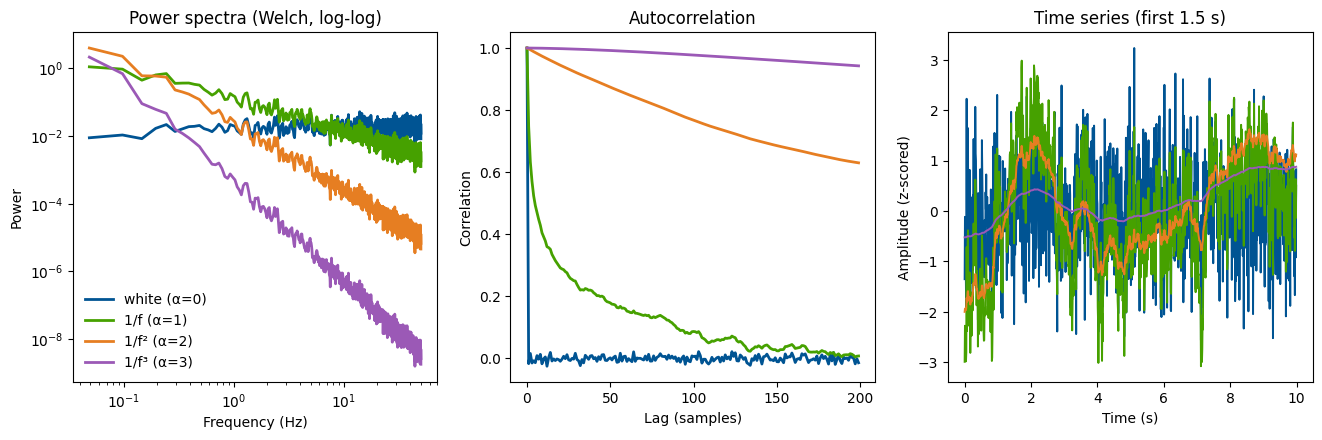

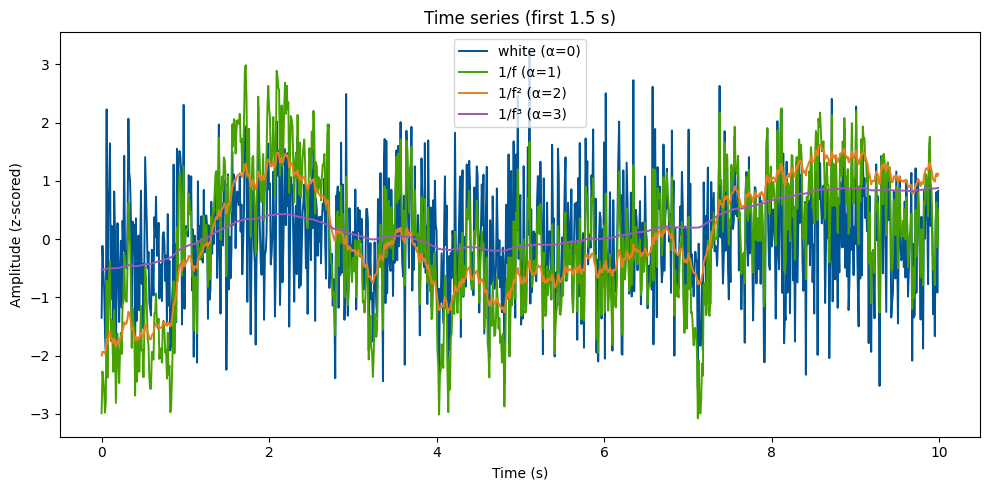

<Figure size 640x480 with 0 Axes>

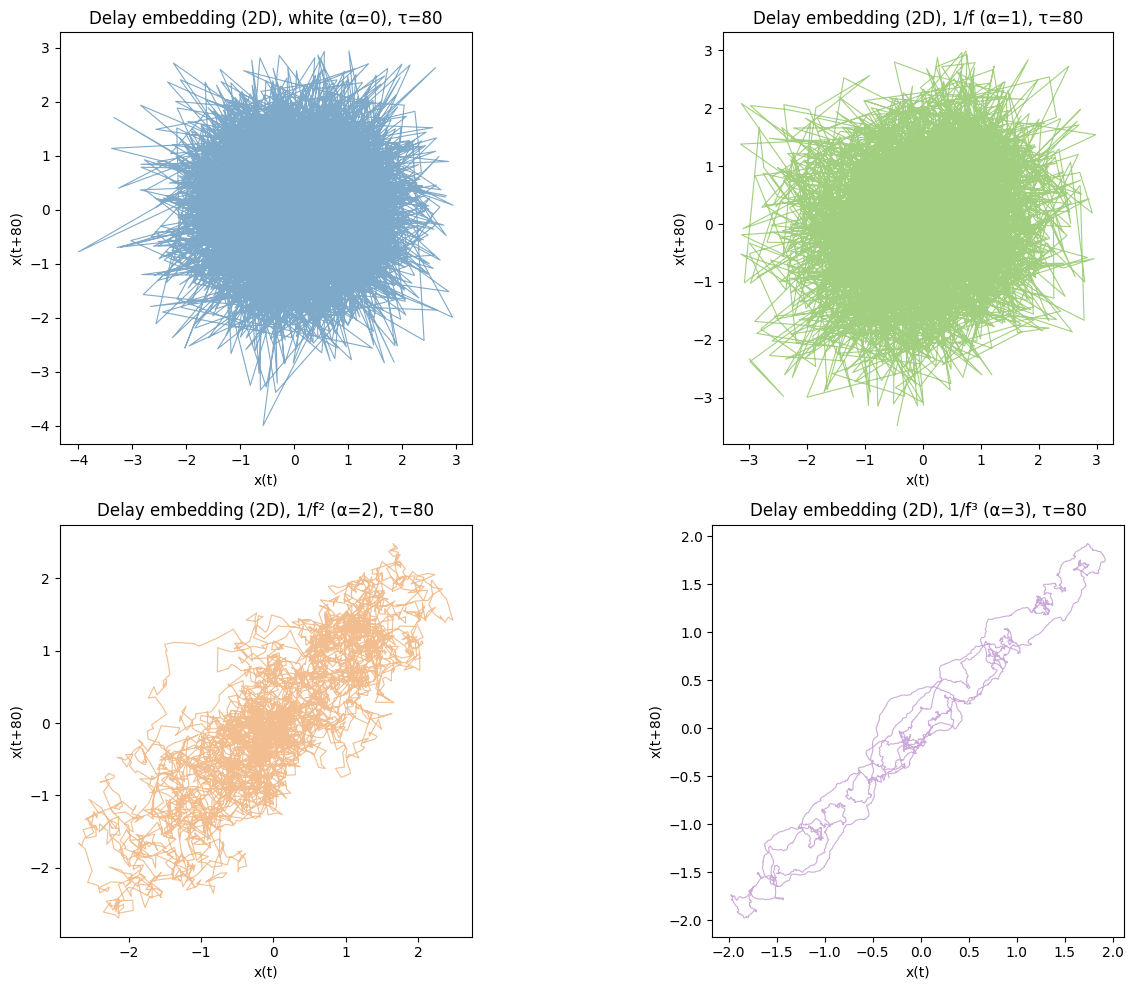

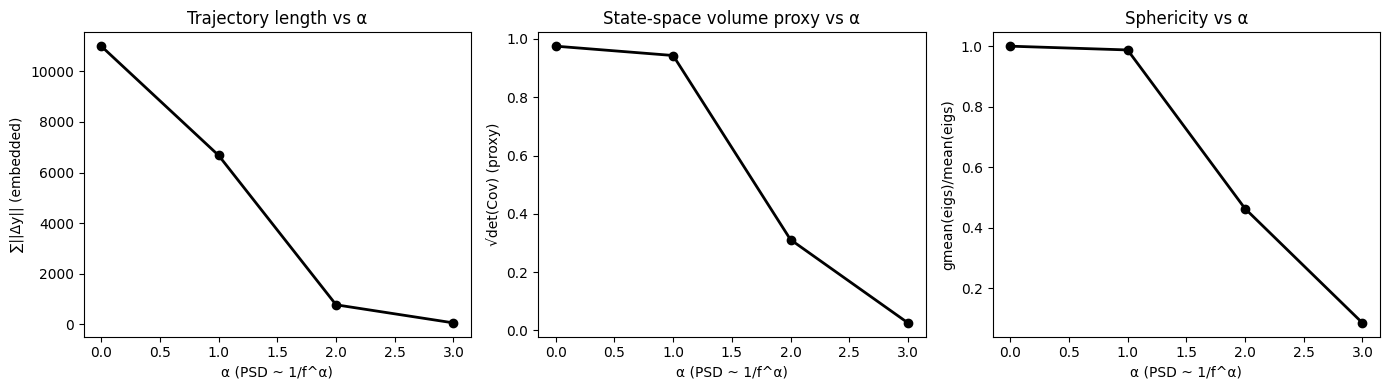

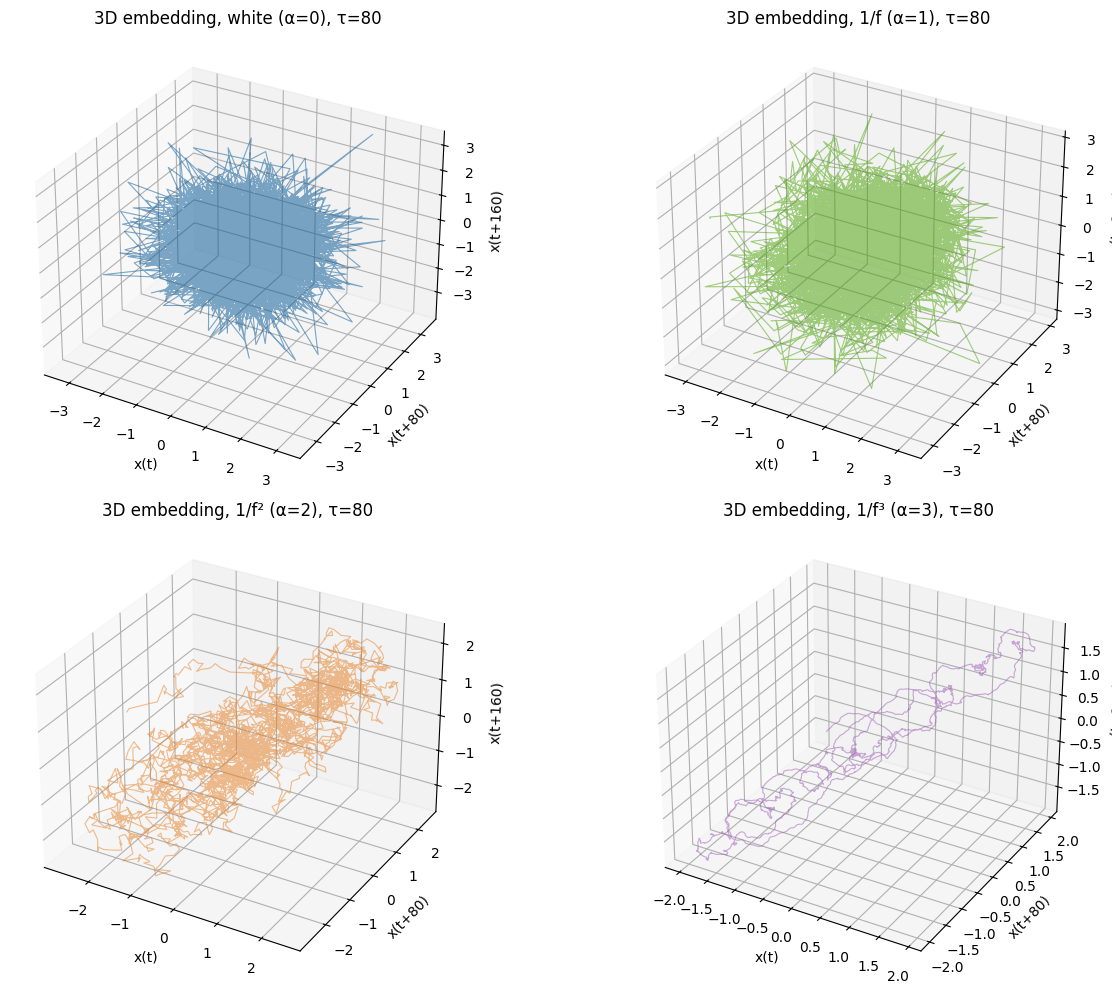

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

def colored_noise_1_over_f(n, fs=1.0, alpha=0.0, seed=0):
    """
    Generate colored noise with PSD ~ 1/f^alpha via frequency-domain shaping.
    alpha=0 -> white, alpha=1 -> pink, alpha=2 -> brown, etc.
    """
    rng = np.random.default_rng(seed)
    freqs = np.fft.rfftfreq(n, d=1.0/fs)

    X = rng.standard_normal(freqs.shape) + 1j * rng.standard_normal(freqs.shape)

    mag = np.ones_like(freqs)
    # power ~ |X|^2, so amplitude scales as 1/f^(alpha/2)
    mag[1:] = 1.0 / (freqs[1:] ** (alpha / 2.0))
    mag[0] = 0.0  # remove DC

    x = np.fft.irfft(X * mag, n=n)
    x = (x - np.mean(x)) / np.std(x)
    return x

def lag_embed(x, tau, m):
    T = len(x) - (m - 1) * tau
    if T <= 2:
        raise ValueError("Time series too short for the chosen tau/m.")
    return np.column_stack([x[i*tau:i*tau+T] for i in range(m)])

def trajectory_length(Y):
    # Sum of Euclidean step lengths in embedded space
    dY = np.diff(Y, axis=0)
    return np.sum(np.linalg.norm(dY, axis=1))

def cov_ellipsoid_volume_proxy(Y):
    """
    Proxy for occupied volume using covariance ellipsoid:
      volume ∝ sqrt(det(Cov(Y)))
    (Constant factor omitted since we compare across alpha.)
    """
    C = np.cov(Y.T)
    detC = np.linalg.det(C)
    detC = max(detC, 0.0)  # numerical guard
    return np.sqrt(detC)

def sphericity_from_cov(Y):
    """
    Sphericity proxy from covariance eigenvalues:
      sphericity = (geometric mean / arithmetic mean) of eigenvalues
    In [0,1], closer to 1 means more spherical/isotropic.
    """
    C = np.cov(Y.T)
    evals = np.linalg.eigvalsh(C)
    evals = np.clip(evals, 1e-12, None)
    gmean = np.exp(np.mean(np.log(evals)))
    amean = np.mean(evals)
    return float(gmean / amean)

# -------------------------
# Settings
# -------------------------
n = 10000
fs = 100.0
seed = 7
tau = 80
m = 3

alphas = [0, 1, 2, 3]  # white, 1/f, 1/f^2, 1/f^3
labels = {
    0: "white (α=0)",
    1: "1/f (α=1)",
    2: "1/f² (α=2)",
    3: "1/f³ (α=3)",
}

# Consistent, distinct colors (requested)
colors = {
    0: (0/255, 84/255, 147/255),   # blue
    1: (70/255, 161/255, 0/255),   # green
    2: (230/255, 126/255, 34/255), # orange
    3: (155/255, 89/255, 182/255), # purple
}

# Transparency: intersections naturally get darker via alpha blending
alpha_line = 0.5
lw = 0.8
show_length = 10

# -------------------------
# Generate signals + metrics
# -------------------------
signals = {}
metrics = {"alpha": [], "traj_len": [], "vol_proxy": [], "sphericity": []}

for a in alphas:
    x = colored_noise_1_over_f(n, fs=fs, alpha=a, seed=seed)
    signals[a] = x

    Y = lag_embed(x, tau=tau, m=m)
    # subsample for stable plotting/metrics without heavy rendering
    Y_sub = Y[::2]

    metrics["alpha"].append(a)
    metrics["traj_len"].append(trajectory_length(Y_sub))
    metrics["vol_proxy"].append(cov_ellipsoid_volume_proxy(Y_sub))
    metrics["sphericity"].append(sphericity_from_cov(Y_sub))

# -------------------------
# Figure 1: multi-panel subfigures
#   Row 1: PSDs
#   Row 2: 2D delay embeddings (x(t), x(t+tau))
#   Row 3: 3D embedding (single panel per alpha, optional) -> keep 2 panels to avoid clutter
# -------------------------
fig = plt.figure(figsize=(16, 10))

# PSD panel
ax_psd = fig.add_subplot(2, 3, 1)
for a in alphas:
    f, Pxx = welch(signals[a], fs=fs, nperseg=2048)
    ax_psd.loglog(f[1:], Pxx[1:], color=colors[a], linewidth=2, label=labels[a])
ax_psd.set_title("Power spectra (Welch, log-log)")
ax_psd.set_xlabel("Frequency (Hz)")
ax_psd.set_ylabel("Power")
ax_psd.legend(frameon=False)

# Autocorrelation panel
def autocorr(x, L):
    x = x - np.mean(x)
    c = np.correlate(x, x, mode="full")
    c = c[c.size//2:]
    return c[:L] / c[0]

ax_ac = fig.add_subplot(2, 3, 2)
for a in alphas:
    ax_ac.plot(autocorr(signals[a], 200), color=colors[a], linewidth=2, label=labels[a])
ax_ac.set_title("Autocorrelation")
ax_ac.set_xlabel("Lag (samples)")
ax_ac.set_ylabel("Correlation")

# Time series snippet
ax_ts = fig.add_subplot(2, 3, 3)
t = np.arange(int(show_length*fs)) / fs
for a in alphas:
    ax_ts.plot(t, signals[a][:len(t)], color=colors[a], linewidth=1.4, label=labels[a])
ax_ts.set_title("Time series (first 1.5 s)")
ax_ts.set_xlabel("Time (s)")
ax_ts.set_ylabel("Amplitude (z-scored)")


# # Time series snippet
# fig = plt.figure(figsize=(14, 10))
# t = np.arange(int(1.5*fs)) / fs
# for a in alphas:
#     fig.plot(t, signals[a][:len(t)], color=colors[a], linewidth=1.4, label=labels[a])
# fig.set_title("Time series (first 1.5 s)")
# fig.set_xlabel("Time (s)")
# fig.set_ylabel("Amplitude (z-scored)")

# Time series snippet
fig, ax = plt.subplots(figsize=(10, 5))

t = np.arange(int(show_length * fs)) / fs

for a in alphas:
    ax.plot(
        t,
        signals[a][:len(t)],
        color=colors[a],
        linewidth=1.4,
        label=labels[a],
    )

ax.set_title("Time series (first 1.5 s)")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Amplitude (z-scored)")
ax.legend()

plt.tight_layout()
plt.show()


# 2D delay embeddings: place 4 panels
positions = [(2,3,4), (2,3,5), (2,3,6)]
# We'll make a second figure for embeddings grid for clarity
plt.tight_layout()
plt.show()

# Embedding grid figure
fig = plt.figure(figsize=(14, 10))
for i, a in enumerate(alphas):
    ax = fig.add_subplot(2, 2, i+1)
    Y2 = lag_embed(signals[a], tau=tau, m=2)[::2]
    ax.plot(Y2[:,0], Y2[:,1], color=colors[a], alpha=alpha_line, linewidth=lw)
    ax.set_title(f"Delay embedding (2D), {labels[a]}, τ={tau}")
    ax.set_xlabel("x(t)")
    ax.set_ylabel(f"x(t+{tau})")
    # Equal aspect helps “circularity” visually
    ax.set_aspect("equal", adjustable="box")
plt.tight_layout()
plt.show()

# -------------------------
# Figure 2: metrics vs alpha
# -------------------------
alph = np.array(metrics["alpha"])
traj = np.array(metrics["traj_len"])
volp = np.array(metrics["vol_proxy"])
sph  = np.array(metrics["sphericity"])

fig = plt.figure(figsize=(14, 4))

ax1 = fig.add_subplot(1, 3, 1)
ax1.plot(alph, traj, marker="o", linewidth=2,color = 'black')
ax1.set_title("Trajectory length vs α")
ax1.set_xlabel("α (PSD ~ 1/f^α)")
ax1.set_ylabel("∑||Δy|| (embedded)")

ax2 = fig.add_subplot(1, 3, 2)
ax2.plot(alph, volp, marker="o", linewidth=2,color = 'black')
ax2.set_title("State-space volume proxy vs α")
ax2.set_xlabel("α (PSD ~ 1/f^α)")
ax2.set_ylabel("√det(Cov) (proxy)")

ax3 = fig.add_subplot(1, 3, 3)
ax3.plot(alph, sph, marker="o", linewidth=2,color = 'black')
ax3.set_title("Sphericity vs α")
ax3.set_xlabel("α (PSD ~ 1/f^α)")
ax3.set_ylabel("gmean(eigs)/mean(eigs)")

plt.tight_layout()
plt.show()

# -------------------------
# Figure 3: 3D embeddings for all alphas (semi-transparent)
# -------------------------
fig = plt.figure(figsize=(14, 10))
for i, a in enumerate(alphas):
    ax = fig.add_subplot(2, 2, i+1, projection="3d")
    Y3 = lag_embed(signals[a], tau=tau, m=3)[::3]
    ax.plot(Y3[:,0], Y3[:,1], Y3[:,2], color=colors[a], alpha=alpha_line, linewidth=lw)
    ax.set_title(f"3D embedding, {labels[a]}, τ={tau}")
    ax.set_xlabel("x(t)")
    ax.set_ylabel(f"x(t+{tau})")
    ax.set_zlabel(f"x(t+{2*tau})")
plt.tight_layout()
plt.show()
